In [1]:
import pandas as pd
import sklearn
from sklearn.model_selection import train_test_split,cross_val_score
from sklearn.linear_model import LinearRegression, Lasso, Ridge
import numpy as np


loan_data  = pd.read_csv("https://raw.githubusercontent.com/dphi-official/Datasets/master/Loan_Data/loan_train.csv" )


%matplotlib inline


In [15]:
ld=loan_data.copy()
ld.head()

,Unnamed: 0,Loan_ID,Gender,Married,Dependents,Education,Self_Employed,ApplicantIncome,CoapplicantIncome,LoanAmount,Loan_Amount_Term,Credit_History,Property_Area,Loan_Status
0,0,LP002305,Female,No,0,Graduate,No,4547,0.0,115.0,360.0,1.0,Semiurban,1
1,1,LP001715,Male,Yes,3+,Not Graduate,Yes,5703,0.0,130.0,360.0,1.0,Rural,1
2,2,LP002086,Female,Yes,0,Graduate,No,4333,2451.0,110.0,360.0,1.0,Urban,0
3,3,LP001136,Male,Yes,0,Not Graduate,Yes,4695,0.0,96.0,NaN,1.0,Urban,1
4,4,LP002529,Male,Yes,2,Graduate,No,6700,1750.0,230.0,300.0,1.0,Semiurban,1


##EDA

In [4]:
ld.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 491 entries, 0 to 490
Data columns (total 14 columns):
Unnamed: 0           491 non-null int64
Loan_ID              491 non-null object
Gender               481 non-null object
Married              490 non-null object
Dependents           482 non-null object
Education            491 non-null object
Self_Employed        462 non-null object
ApplicantIncome      491 non-null int64
CoapplicantIncome    491 non-null float64
LoanAmount           475 non-null float64
Loan_Amount_Term     478 non-null float64
Credit_History       448 non-null float64
Property_Area        491 non-null object
Loan_Status          491 non-null int64
dtypes: float64(4), int64(3), object(7)
memory usage: 53.8+ KB


In [6]:
ld.Loan_Status.value_counts()

1    343
0    148
Name: Loan_Status, dtype: int64

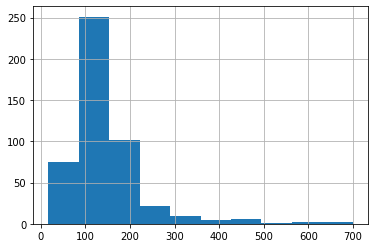

In [7]:
ld.LoanAmount.hist()

In [9]:
ld.Education.unique()

array(['Graduate', 'Not Graduate'], dtype=object)

In [10]:
ld.Self_Employed.unique()

array(['No', 'Yes', nan], dtype=object)

In [11]:
ld.Dependents.unique()

array(['0', '3+', '2', '1', nan], dtype=object)

In [12]:
ld.Loan_Amount_Term.unique()

array([360.,  nan, 300., 180.,  84., 480., 240., 120.,  36.,  12.,  60.])

In [2]:
categorical_columns = ['Gender', 'Married', 'Dependents', 'Education', 'Self_Employed', 'Property_Area','Credit_History','Loan_Amount_Term']
numerical_columns =['ApplicantIncome', 'CoapplicantIncome', 'LoanAmount']


In [16]:
ld.drop('Loan_ID',axis=1,inplace=True)

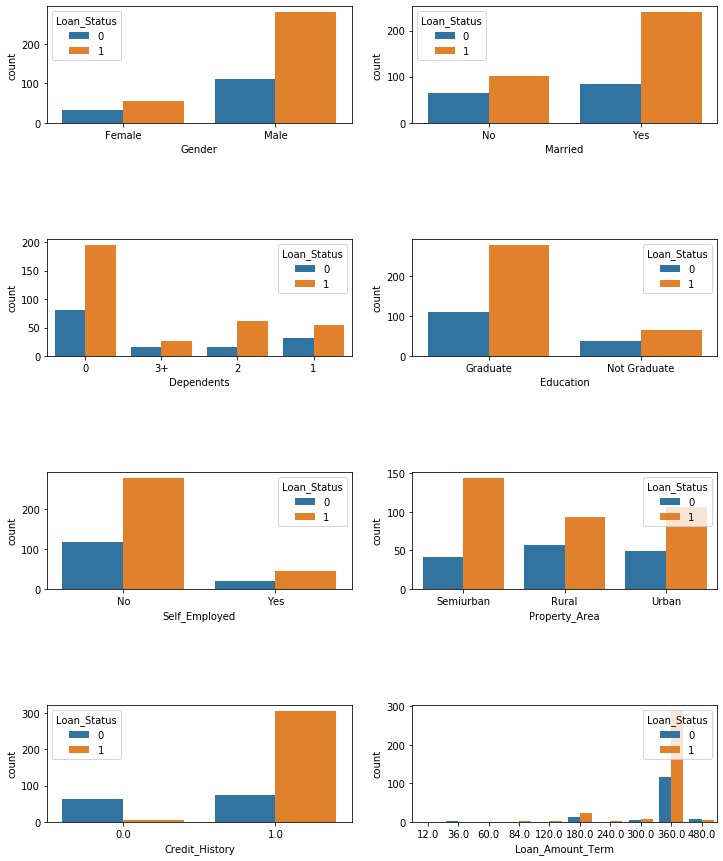

In [19]:
import seaborn as sns
import matplotlib.pyplot as plt


fig,axes = plt.subplots(4,2,figsize=(12,15))
for idx,cat_col in enumerate(categorical_columns):
    row,col = idx//2,idx%2
    sns.countplot(x=cat_col,data=ld,hue='Loan_Status',ax=axes[row,col])


plt.subplots_adjust(hspace=1)

 FROM ABOVE , we see that :
 1. Married people are almost 2x in number and their chances of loan approved is also high. Also number of male applicants are   more.
 2. zero dependents ,graduates residing in semi urban property  are having more loan approvals.
 3. Applicant with credit history are far more likely to be accepted.
 4. Loan Amount Term: Majority of the loans taken are for 360 Months (30 years).
Majority of applicants are self employed and are males.


Text(0.5, 0.98, '')

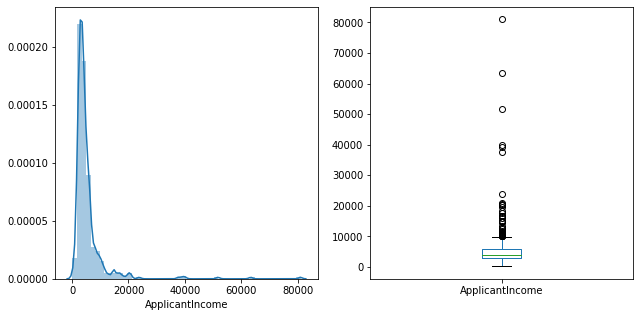

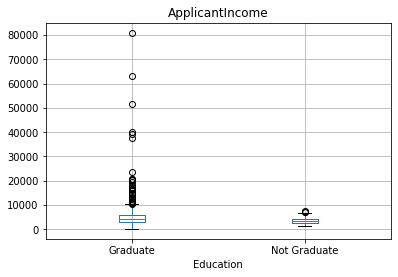

In [22]:
### NUMERICAL DATA
plt.figure(1) 
plt.subplot(131) 
sns.distplot(ld['ApplicantIncome']); 
plt.subplot(132) 
ld['ApplicantIncome'].plot.box(figsize=(16,5)) 
ld.boxplot(column='ApplicantIncome', by = 'Education') 
plt.suptitle("")

Inferences :

1.Income distribution is skewed to the left, hence normalisation would be required for better performance of the model.

2 .Box plot shows that there are quite a few outliers who are mostly "Graduate"

In [24]:

bins_loan_amount=[0,100,200,700] 
group=['Low','Average','High'] 
ld['LoanAmount_buckets']=pd.cut(ld['LoanAmount'],bins_loan_amount,labels=group)

In [27]:

LoanAmount_buckets=pd.crosstab(ld['LoanAmount_buckets'],ld['Loan_Status']) 

In [29]:
LoanAmount_buckets.sum(1)

LoanAmount_buckets
Low        128
Average    287
High        60
dtype: int64

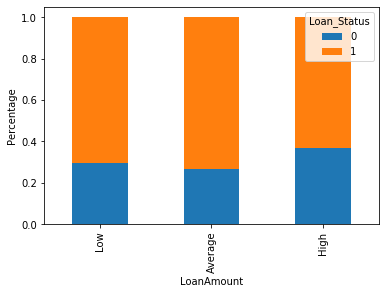

In [30]:
LoanAmount_buckets.div(LoanAmount_buckets.sum(1).astype(float), axis=0).plot(kind="bar", stacked=True) 
plt.xlabel('LoanAmount') 
P = plt.ylabel('Percentage')
plt.show()

Low and Average income people have higher percentage of loan approvals.

### FEATURE ENGINEERING 
We shall encode label 'Yes' to 1 and 'No' to 0|

In [17]:
test_data = pd.read_csv('https://raw.githubusercontent.com/dphi-official/Datasets/master/Loan_Data/loan_test.csv')

In [18]:
test_data.drop('Loan_ID',axis=1,inplace=True)

In [19]:
### TREATING MISSING VALUES
ld['Gender'].fillna(ld['Gender'].mode()[0],inplace=True)  ## male
ld['Married'].fillna(ld['Married'].mode()[0], inplace=True) 
ld['Dependents'].fillna(ld['Dependents'].mode()[0], inplace=True) 
ld['Self_Employed'].fillna(ld['Self_Employed'].mode()[0], inplace=True) 
ld['Credit_History'].fillna(ld['Credit_History'].mode()[0], inplace=True)

ld['Loan_Amount_Term'].fillna(ld['Loan_Amount_Term'].mode()[0], inplace=True)
ld['LoanAmount'].fillna(ld['LoanAmount'].median(), inplace=True)  ## numerical column



In [20]:
test_data['Gender'].fillna(test_data['Gender'].mode()[0],inplace=True)  
test_data['Married'].fillna(test_data['Married'].mode()[0], inplace=True) 
test_data['Dependents'].fillna(test_data['Dependents'].mode()[0], inplace=True) 
test_data['Self_Employed'].fillna(test_data['Self_Employed'].mode()[0], inplace=True) 
test_data['Credit_History'].fillna(test_data['Credit_History'].mode()[0], inplace=True)

test_data['Loan_Amount_Term'].fillna(test_data['Loan_Amount_Term'].mode()[0], inplace=True)
test_data['LoanAmount'].fillna(test_data['LoanAmount'].median(), inplace=True)  ## numerical column

In [21]:
##numerical encoding
ld['Married']=ld["Married"].map({'Yes':1,"No":0})
test_data['Married']=test_data["Married"].map({'Yes':1,"No":0})
ld['Self_Employed']=ld['Self_Employed'].map({'Yes':1,"No":0})
test_data['Self_Employed']=test_data['Self_Employed'].map({'Yes':1,"No":0})
ld['Gender']=ld['Gender'].map({'Male':1,'Female':0})
test_data['Gender']=test_data["Gender"].map({'Male':1,"Female":0})
#test_data['Education']=test_data['Education'].map({'Graduate':1,'Not Graduate':0})
#ld['Education']=ld['Education'].map({'Graduate':1,'Not Graduate':0})
ld['Property_Area']=ld['Property_Area'].map({'Urban':1,'Semiurban':2,'Rural':1})
test_data['Property_Area']=test_data['Property_Area'].map({'Urban':1,'Semiurban':2,'Rural':1})

In [22]:
ld['Dependents'].replace('3+', 3,inplace=True) 
test_data['Dependents'].replace('3+', 3,inplace=True) 


In [23]:
# One Hot Encoding
ld1=pd.get_dummies(data=ld,columns=['Education'],prefix_sep='-',drop_first=True)
test_Data1=pd.get_dummies(data=test_data,columns=['Education'],prefix_sep='-',drop_first=True)

In [24]:
ld1.drop(['Unnamed: 0'],axis=1,inplace=True)

In [26]:
test_Data1.head(5)

,Gender,Married,Dependents,Self_Employed,ApplicantIncome,CoapplicantIncome,LoanAmount,Loan_Amount_Term,Credit_History,Property_Area,Education-Not Graduate
0,1,0,0,0,3748,1668.0,110.0,360.0,1.0,2,1
1,1,1,3,0,4000,7750.0,290.0,360.0,1.0,2,0
2,1,1,0,0,2625,6250.0,187.0,360.0,1.0,1,0
3,1,0,0,0,3902,1666.0,109.0,360.0,1.0,1,1
4,1,1,0,0,6096,0.0,218.0,360.0,0.0,1,1


### MODEL BUILDING

In [27]:
x = ld1.drop('Loan_Status',1)
y = ld1.Loan_Status

In [28]:
from sklearn.model_selection import train_test_split

X_train,X_test,y_train,y_test = train_test_split(x,y,test_size=0.2,stratify =y,random_state =42)

In [29]:
from sklearn.metrics import f1_score,accuracy_score
from sklearn.ensemble import RandomForestClassifier
rf_clf = RandomForestClassifier(n_estimators=100,max_depth=3,min_samples_leaf = 10)
rf_clf.fit(X_train,y_train)
y_pred = rf_clf.predict(X_test)
print("Test F1 Score ", f1_score(y_test,y_pred))
print("Test Accuracy ", accuracy_score(y_test,y_pred))

print("Validation Mean F1 Score: ",cross_val_score(rf_clf,X_train,y_train,cv=5,scoring='f1_macro').mean())
print("Validation Mean Accuracy: ",cross_val_score(rf_clf,X_train,y_train,cv=5,scoring='accuracy').mean())

Test F1 Score  0.8918918918918919
Test Accuracy  0.8383838383838383
Validation Mean F1 Score:  0.7082102563100736
Validation Mean Accuracy:  0.806166828951639


In [30]:
from sklearn.linear_model import LogisticRegression
params={'class_weight':['balanced',None],
'penalty':['l1','l2'],
'C':np.linspace(0.0001,1000,10)}
# we can certainly try much higher ranges
model=LogisticRegression(fit_intercept=True)

In [32]:
from sklearn.model_selection import GridSearchCV
grid_search=GridSearchCV(model,param_grid=params,cv=10,scoring="f1_macro",n_jobs=-1)
grid_search.fit(X_train,y_train)

C:\Users\kshor.jadhav\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:764: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


GridSearchCV(cv=10, estimator=LogisticRegression(), n_jobs=-1,
             param_grid={'C': array([1.000000e-04, 1.111112e+02, 2.222223e+02, 3.333334e+02,
       4.444445e+02, 5.555556e+02, 6.666667e+02, 7.777778e+02,
       8.888889e+02, 1.000000e+03]),
                         'class_weight': ['balanced', None],
                         'penalty': ['l1', 'l2']},
             scoring='f1_macro')

In [33]:
lr=grid_search.best_estimator_
y_pred=lr.predict(X_test)
print("Test F1 Score ", f1_score(y_test,y_pred))
print("Test Accuracy ", accuracy_score(y_test,y_pred))



Test F1 Score  0.8904109589041096
Test Accuracy  0.8383838383838383


In [38]:
Y_pred=lr.predict(test_Data1)
res = pd.DataFrame(Y_pred) #preditcions are nothing but the final predictions of your model on input features of your new unseen test data
res.index =test_Data1.index # its important for comparison. Here "test_new" is your new test dataset
res.columns = ["prediction"]
#res.to_csv("prediction_results.csv", index = False)      # the csv file will be saved locally on the same location where this notebook is located.

In [39]:
test_Data1.shape

(123, 11)

In [35]:
import pickle
pickle.dump(lr, open('model.pkl','wb'))


In [52]:

model_columns = list(x.columns)
pickle.dump(model_columns,open('model_columns.pkl','wb'))

In [37]:
import pickle
import numpy as np
import pandas as pd

model = pickle.load(open("model.pkl", "rb"))
print(model)
print('done')

LogisticRegression(C=111.11120000000001)
done


In [55]:
input_data=[{
    'income1':400000,
    'income2':29999,
    'LoanAmount':20000,
    'Loan_Amount_Term':36,
    'Dependents': 0,
    'Credit_History':0,
    'Self_Employed':1,
    'Property_Area':1,
    'Education':'Graduate',
    'Married':1,
    'Gender':0
    }]


dataset=pd.DataFrame(input_data)
print(dataset)
print('Shape of dATAFRAME', dataset.shape)
#model_columns = pickle.load(open("model_columns.pkl","rb"))
#int_features = [x for x in request.form.values()]
print('Dummification for one feature')
print('Dummification for one feature')
query = pd.get_dummies(data=dataset,columns=['Education'],prefix_sep='-')
print(query)
#query = query.reindex(columns=model_columns, fill_value=0)
query = pd.get_dummies(data=dataset,columns=['Education'])
print(query)
print('After dummification :',query.shape)
final_features = np.array(query)
print(final_features)
print(final_features.shape)
prediction = model.predict(final_features)

   Credit_History  Dependents Education  Gender  LoanAmount  Loan_Amount_Term  \
0               0           0  Graduate       0       20000                36   

   Married  Property_Area  Self_Employed  income1  income2  
0        1              1              1   400000    29999  
Shape of dATAFRAME (1, 11)
Dummification for one feature
Dummification for one feature
   Credit_History  Dependents  Gender  LoanAmount  Loan_Amount_Term  Married  \
0               0           0       0       20000                36        1   

   Property_Area  Self_Employed  income1  income2  Education-Graduate  
0              1              1   400000    29999                   1  
   Credit_History  Dependents  Gender  LoanAmount  Loan_Amount_Term  Married  \
0               0           0       0       20000                36        1   

   Property_Area  Self_Employed  income1  income2  Education_Graduate  
0              1              1   400000    29999                   1  
After dummificatio

In [53]:
prediction[0]

1